# Modeling

### Import Relevant Libraries

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, snowball
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.util import ngrams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder 
from nltk.util import ngrams

nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix, classification_report, r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\capta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read in Processed Data

In [64]:
df = pd.read_parquet('./Data/processed_reports.parquet')

In [65]:
df.reset_index(inplace=True)

In [66]:
df.drop(['index'],axis=1,inplace=True)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Data columns (total 99 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player                       4209 non-null   object 
 1   report                       4209 non-null   object 
 2   year                         4209 non-null   float64
 3   weight_x                     3986 non-null   float64
 4   height_x                     3986 non-null   float64
 5   pos_rk                       3871 non-null   float64
 6   ovr_rk                       3292 non-null   float64
 7   grade                        3877 non-null   float64
 8   age                          3897 non-null   float64
 9   Round                        4209 non-null   Int64  
 10  Pick                         4209 non-null   Int64  
 11  target                       4209 non-null   Int64  
 12  processed_report             4209 non-null   object 
 13  reportlen         

In [68]:
df['target'] = df.Round

In [69]:
df.target[df.target >= 6] = 0

In [70]:
df.target[df.target == 1] = 10

In [71]:
df.target[(df.target == 4) | (df.target == 5)] = 1

In [72]:
df.target[df.target == 3] = 2

In [73]:
df.target[df.target == 10] = 3

In [74]:
cleaned_df = df.drop(['report','processed_report','joined_report','weight_y','height_y'],axis=1) 

In [75]:
cleaned_df = cleaned_df.add_suffix('_col')

In [76]:
cleaned_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,tackles_loss_career_col,sacks_career_col,pass_defended_career_col,fumbles_forced_season_col,fumbles_forced_career_col,college_conference_col,speed_col,shuttle_agility_col,cone_agility_col,pos_col
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,NaN,NaN,NaN,NaN,NaN,Mountain West Conference,88.187311,176.485482,136.815911,QB
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,NaN,NaN,NaN,NaN,NaN,None,120.996000,168.168738,130.199966,RB
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,NaN,NaN,NaN,NaN,NaN,None,107.614900,NaN,NaN,WR
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,NaN,NaN,NaN,NaN,NaN,None,97.457455,NaN,NaN,RB
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,RB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,252,...,38.5,17.0,4.0,2.0,9.0,Sun Belt Conference,105.744617,144.109521,137.671457,LB
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,NaN,NaN,NaN,NaN,NaN,Atlantic Coast Conference,NaN,NaN,NaN,P
4206,Jesse Luketa,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,256,...,11.5,0.5,6.0,NaN,NaN,Big Ten Conference,88.494256,NaN,NaN,LB
4207,Marquis Hayes,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,257,...,NaN,NaN,NaN,NaN,NaN,Big Twelve Conference,80.603451,NaN,NaN,OL


In [77]:
tf = TfidfVectorizer(ngram_range=(1,3),min_df=.062,max_df =.75)

In [78]:
X = tf.fit_transform(df.joined_report)

In [79]:
report_df = pd.DataFrame(X.toarray(),columns=tf.get_feature_names())

In [80]:
report_df.columns

Index(['2002', '2003', '2004', '2005', '2006', '2016', 'abil', 'adequ', 'also',
       'appear',
       ...
       'two season', 'upsid', 'valu', 'versatil', 'well', 'work', 'yard',
       'year', 'year starter', 'zone'],
      dtype='object', length=198)

In [81]:
model_df = pd.concat([cleaned_df,report_df],axis=1)

In [82]:
model_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,two season,upsid,valu,versatil,well,work,yard,year,year starter,zone
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.302746,0.197995,0.0,0.000000
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,0.0,0.0,0.0,0.128312,0.0,0.130273,0.338669,0.000000,0.0,0.000000
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.261304,0.113928,0.0,0.000000
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.200609,0.000000,0.0,0.000000
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.282241,0.061528,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,252,...,0.0,0.0,0.0,0.199357,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.370394,0.000000,0.0,0.000000
4206,Jesse Luketa,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,256,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4207,Marquis Hayes,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,257,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.237427


### Linear Regression

In [83]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('lin',LinearRegression())
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
}

lin = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [84]:
lin.fit(X_train,y_train)
y_pred = lin.predict(X_test)
print(r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

0.4901565629798307 2530.820585660758


(0.0, 270.0)

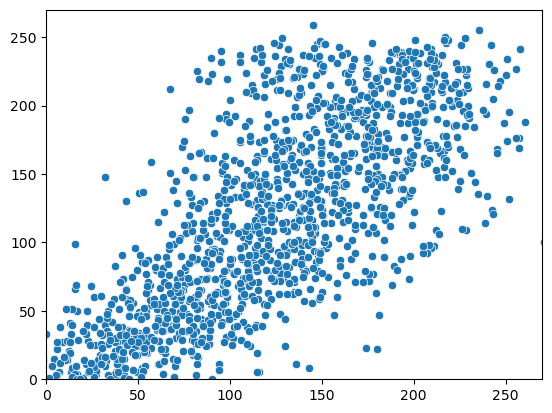

In [23]:
sns.scatterplot(y_pred,y_test)
plt.xlim(0,270)
plt.ylim(0,270)

### Random Forest

In [24]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col
player_pos = X_test.pos_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

rfc_pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('forest',RandomForestRegressor())
])

rfc_pipe.fit(X_train, y_train)

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'forest__n_estimators':[102],
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'forest__max_depth':[24],
    'forest__min_samples_split':[2],
    'forest__min_samples_leaf':[6]
}

forest = GridSearchCV(estimator=rfc_pipe,
                          param_grid=grid,
                          cv=5)

In [25]:
start_time = time.time()
forest.fit(X_train,y_train)
print(((time.time() - start_time)/60),'minutes')
y_pred_forest = forest.predict(X_test)
print(r2_score(y_test,y_pred_forest),mean_squared_error(y_test,y_pred_forest));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

3.128630236784617 minutes
0.6581159395302798 1697.084154310348


In [26]:
rfc_pipe[0].transformers_[1][1].named_steps['ohe'].get_feature_names()

array(['x0_Atlantic Coast Conference', 'x0_Big East',
       'x0_Big Sky Conference', 'x0_Big South Conference',
       'x0_Big Ten Conference', 'x0_Big Twelve Conference',
       'x0_Central Intercollegiate Athletic Association',
       'x0_Colonial Athletic Association', 'x0_Conference USA',
       'x0_Great Lakes Intercollegiate Athletic Conference',
       'x0_Great Northwest Athletic Conference',
       'x0_Great West Football Conference', 'x0_Gulf South Conference',
       'x0_Independent', 'x0_Ivy League', 'x0_Lone Star Conference',
       'x0_Mid-America Intercollegiate Athletic Association',
       'x0_Mid-American Conference', 'x0_Mid-Eastern Athletic Conference',
       'x0_Minnesota Intercollegiate Athletic Conference',
       'x0_Missouri Valley Football Conference',
       'x0_Mountain West Conference', 'x0_Northeast Conference',
       'x0_Northern Sun Intercollegiate Conference',
       'x0_Ohio Athletic Conference', 'x0_Ohio Valley Conference',
       'x0_Pacific Twelv

In [27]:
X_train.columns.to_list()

['weight_x_col',
 'height_x_col',
 'pos_rk_col',
 'ovr_rk_col',
 'grade_col',
 'age_col',
 'reportlen_col',
 'forty_yd_col',
 'vertical_col',
 'bench_reps_col',
 'broad_jump_col',
 'cone_col',
 'shuttle_col',
 'g_season_col',
 'def_int_season_col',
 'def_int_yds_season_col',
 'def_int_yds_per_int_season_col',
 'def_int_career_col',
 'def_int_yds_career_col',
 'def_int_yds_per_int_career_col',
 'pass_cmp_season_col',
 'pass_att_season_col',
 'pass_cmp_pct_season_col',
 'pass_yds_season_col',
 'pass_yds_per_att_season_col',
 'adj_pass_yds_per_att_season_col',
 'pass_td_season_col',
 'pass_int_season_col',
 'pass_rating_season_col',
 'pass_cmp_career_col',
 'pass_att_career_col',
 'pass_cmp_pct_career_col',
 'pass_yds_career_col',
 'pass_yds_per_att_career_col',
 'adj_pass_yds_per_att_career_col',
 'pass_td_career_col',
 'pass_int_career_col',
 'pass_rating_career_col',
 'rush_att_season_col',
 'rush_yds_season_col',
 'rush_yds_per_att_season_col',
 'rush_td_season_col',
 'rec_season_col'

In [28]:
feature_cols = ['weight_x_col',
 'height_x_col',
 'pos_rk_col',
 'ovr_rk_col',
 'grade_col',
 'age_col',
 'reportlen_col',
 'forty_yd_col',
 'vertical_col',
 'bench_reps_col',
 'broad_jump_col',
 'cone_col',
 'shuttle_col',
 'g_season_col',
 'def_int_season_col',
 'def_int_yds_season_col',
 'def_int_yds_per_int_season_col',
 'def_int_career_col',
 'def_int_yds_career_col',
 'def_int_yds_per_int_career_col',
 'pass_cmp_season_col',
 'pass_att_season_col',
 'pass_cmp_pct_season_col',
 'pass_yds_season_col',
 'pass_yds_per_att_season_col',
 'adj_pass_yds_per_att_season_col',
 'pass_td_season_col',
 'pass_int_season_col',
 'pass_rating_season_col',
 'pass_cmp_career_col',
 'pass_att_career_col',
 'pass_cmp_pct_career_col',
 'pass_yds_career_col',
 'pass_yds_per_att_career_col',
 'adj_pass_yds_per_att_career_col',
 'pass_td_career_col',
 'pass_int_career_col',
 'pass_rating_career_col',
 'rush_att_season_col',
 'rush_yds_season_col',
 'rush_yds_per_att_season_col',
 'rush_td_season_col',
 'rec_season_col',
 'rec_yds_season_col',
 'rec_yds_per_rec_season_col',
 'scrim_att_season_col',
 'scrim_yds_season_col',
 'scrim_yds_per_att_season_col',
 'scrim_td_season_col',
 'rush_att_career_col',
 'rush_yds_career_col',
 'rush_yds_per_att_career_col',
 'rush_td_career_col',
 'rec_career_col',
 'rec_yds_career_col',
 'rec_yds_per_rec_career_col',
 'rec_td_career_col',
 'scrim_att_career_col',
 'scrim_yds_career_col',
 'scrim_yds_per_att_career_col',
 'scrim_td_career_col',
 'fumbles_rec_yds_career_col',
 'fumbles_rec_td_career_col',
 'rec_td_season_col',
 'def_int_td_season_col',
 'def_int_td_career_col',
 'fumbles_rec_career_col',
 'fumbles_rec_yds_season_col',
 'fumbles_rec_td_season_col',
 'fumbles_rec_season_col',
 'tackles_solo_season_col',
 'tackles_assists_season_col',
 'tackles_total_season_col',
 'tackles_loss_season_col',
 'sacks_season_col',
 'pass_defended_season_col',
 'tackles_solo_career_col',
 'tackles_assists_career_col',
 'tackles_total_career_col',
 'tackles_loss_career_col',
 'sacks_career_col',
 'pass_defended_career_col',
 'fumbles_forced_season_col',
 'fumbles_forced_career_col',
 'x0_Atlantic Coast Conference', 'x0_Big East',
       'x0_Big Sky Conference', 'x0_Big South Conference',
       'x0_Big Ten Conference', 'x0_Big Twelve Conference',
       'x0_Central Intercollegiate Athletic Association',
       'x0_Colonial Athletic Association', 'x0_Conference USA',
       'x0_Great Lakes Intercollegiate Athletic Conference',
       'x0_Great Northwest Athletic Conference',
       'x0_Great West Football Conference', 'x0_Gulf South Conference',
       'x0_Independent', 'x0_Ivy League', 'x0_Lone Star Conference',
       'x0_Mid-America Intercollegiate Athletic Association',
       'x0_Mid-American Conference', 'x0_Mid-Eastern Athletic Conference',
       'x0_Minnesota Intercollegiate Athletic Conference',
       'x0_Missouri Valley Football Conference',
       'x0_Mountain West Conference', 'x0_Northeast Conference',
       'x0_Northern Sun Intercollegiate Conference',
       'x0_Ohio Athletic Conference', 'x0_Ohio Valley Conference',
       'x0_Pacific Twelve Conference', 'x0_Patriot League',
       'x0_Pennsylvania State Athletic Conference',
       'x0_Pioneer Football League', 'x0_South Atlantic Conference',
       'x0_Southeastern Conference', 'x0_Southern Conference',
       'x0_Southern Intercollegiate Athletic Conference',
       'x0_Southland Conference', 'x0_Southwestern Athletic Conference',
       'x0_Sun Belt Conference', 'x0_Western Athletic Conference',
       'x0_Wisconsin Intercollegiate Athletic Conference','x0_None','speed_col',
 'shuttle_agility_col',
 'cone_agility_col','x1_DB', 'x1_DE', 'x1_DL', 'x1_DT', 'x1_FB', 'x1_K', 'x1_LB',
       'x1_LS', 'x1_OL', 'x1_P', 'x1_QB', 'x1_RB', 'x1_S', 'x1_TE',
       'x1_WR','2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2016',
 'abil',
 'adequ',
 'also',
 'appear',
 'arm',
 'athlet',
 'athlet abil',
 'athletic',
 'averag',
 'back',
 'backup',
 'ball',
 'ball skill',
 'best',
 'better',
 'big',
 'block',
 'blocker',
 'bodi',
 'burst',
 'career',
 'catch',
 'class',
 'close',
 'colleg',
 'combin',
 'come',
 'concern',
 'consist',
 'contribut',
 'corner',
 'could',
 'coverag',
 'day',
 'defend',
 'defens',
 'develop',
 'draft',
 'durabl',
 'earli',
 'edg',
 'effect',
 'eight',
 'elit',
 'end',
 'end speed',
 'enough',
 'excel',
 'experi',
 'explos',
 'field',
 'final',
 'finish',
 'first',
 'fit',
 'five',
 'flash',
 'flash abil',
 'footbal',
 'forc',
 'four',
 'frame',
 'freshman',
 'fumbl',
 'game',
 'get',
 'good',
 'grade',
 'great',
 'guard',
 'hand',
 'high',
 'howev',
 'ideal',
 'improv',
 'inconsist',
 'injuri',
 'insid',
 'instinct',
 'intercept',
 'job',
 'junior',
 'lack',
 'lack ideal',
 'last',
 'late',
 'left',
 'length',
 'level',
 'like',
 'limit',
 'line',
 'lineback',
 'long',
 'loss',
 'lot',
 'make',
 'man',
 'miss',
 'move',
 'much',
 'natur',
 'need',
 'nfl',
 'offens',
 'one',
 'outsid',
 'outstand',
 'overal',
 'pass',
 'pass rusher',
 'physic',
 'pick',
 'play',
 'play game',
 'player',
 'point',
 'posit',
 'possess',
 'potenti',
 'power',
 'pro',
 'product',
 'project',
 'prospect',
 'quarterback',
 'quick',
 'rang',
 'receiv',
 'record',
 'redshirt',
 'return',
 'right',
 'round',
 'round pick',
 'rout',
 'rout runner',
 'run',
 'run defend',
 'runner',
 'rush',
 'rusher',
 'sack',
 'safeti',
 'scheme',
 'season',
 'second',
 'senior',
 'set',
 'short',
 'show',
 'six',
 'size',
 'skill',
 'special',
 'special team',
 'speed',
 'start',
 'start game',
 'starter',
 'still',
 'strength',
 'strong',
 'tackl',
 'tackl loss',
 'take',
 'team',
 'techniqu',
 'term',
 'three',
 'three season',
 'tight',
 'time',
 'top',
 'top end',
 'top end speed',
 'total',
 'touchdown',
 'tough',
 'true',
 'true freshman',
 'two',
 'two season',
 'upsid',
 'valu',
 'versatil',
 'well',
 'work',
 'yard',
 'year',
 'year starter',
 'zone']

In [29]:
weights = rfc_pipe[-1].feature_importances_

In [30]:
coefs = pd.DataFrame(zip(feature_cols,weights))

In [31]:
coefs.sort_values(by=1,ascending=False).head(20)

,0,1
3,ovr_rk_col,0.532186
4,grade_col,0.110923
6,reportlen_col,0.014684
84,x0_Atlantic Coast Conference,0.010017
2,pos_rk_col,0.009923
140,x1_TE,0.007925
1,height_x_col,0.007110
7,forty_yd_col,0.006681
0,weight_x_col,0.006176
86,x0_Big Sky Conference,0.004555


(0.0, 270.0)

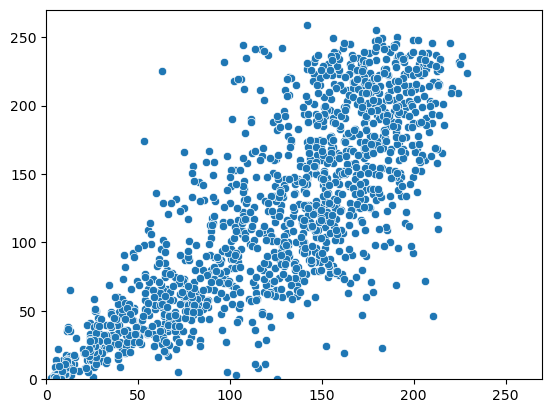

In [32]:
sns.scatterplot(y_pred_forest,y_test)
plt.xlim(0,270)
plt.ylim(0,270)

### KNN

In [48]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col
player_pos = X_test.pos_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('knn',KNeighborsRegressor())
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'knn__n_neighbors':[30,40]
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#     'forest__max_depth':[4,12,None],
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

knn = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [49]:
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)
print(r2_score(y_test,y_pred_knn),mean_squared_error(y_test,y_pred_knn));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\

0.20151397149746042 3963.618498470122


(0.0, 270.0)

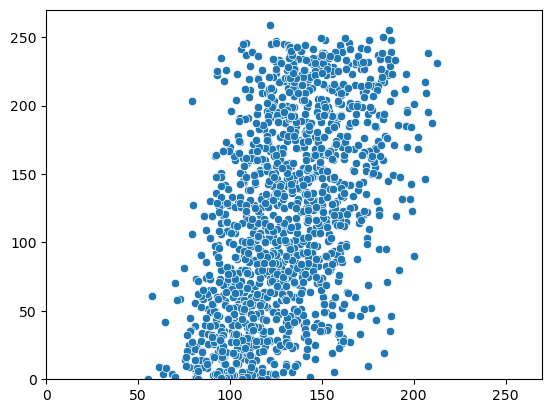

In [35]:
sns.scatterplot(y_pred_knn,y_test)
plt.xlim(0,270)
plt.ylim(0,270)

### Decision Tree

In [36]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col
player_pos = X_test.pos_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('tree',DecisionTreeRegressor(random_state=42))
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)]
#     'tree__n_estimators':[75,100,125],
#     'tree__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#     'tree__max_depth':[4,12,None],
#     'tree__min_samples_split':[1,2,3],
#     'tree__min_samples_leaf':[1,2,3]
}

tree = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [37]:
tree.fit(X_train,y_train)
y_pred_tree = tree.predict(X_test)
print(r2_score(y_test,y_pred_tree),mean_squared_error(y_test,y_pred_tree));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

0.34642468190258413 3244.29373650108


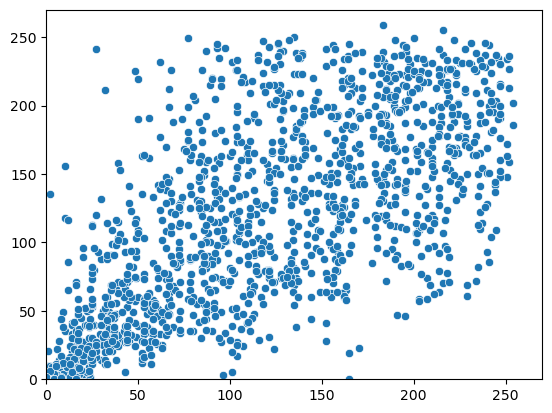

In [38]:
sns.scatterplot(y_pred_tree,y_test)
plt.xlim(0,270)
plt.ylim(0,270);

### XGBoost

In [39]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col
player_pos = X_test.pos_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('xgb',XGBRegressor())
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'xgb__max_depth':[2,1],
    'xgb__eta':[.23,.24],
    'xgb__gamma':[0,.5]
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

xgb = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [41]:
start_time = time.time()
xgb.fit(X_train,y_train)
print(((time.time() - start_time)/60),'minutes')
y_pred_xgb = xgb.predict(X_test)
print(r2_score(y_test,y_pred_xgb),mean_squared_error(y_test,y_pred_xgb));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta

0.9343719561894734 minutes
0.6364090867939968 1804.8351730857812


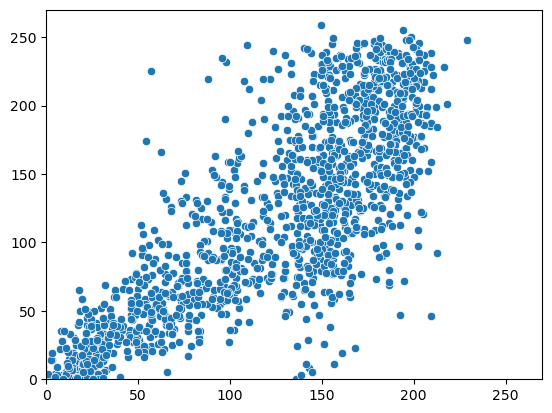

In [42]:
sns.scatterplot(y_pred_xgb,y_test)
plt.xlim(0,270)
plt.ylim(0,270);

### ADABoost

In [43]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col
player_pos = X_test.pos_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('ada',AdaBoostRegressor(random_state=42))
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'ada__n_estimators':[42,40],
    'ada__learning_rate':[.35],
    'ada__loss':['linear','square','exponential']
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

ada = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [44]:
start_time = time.time()
ada.fit(X_train,y_train)
print(((time.time() - start_time)/60),'minutes')
y_pred_ada = ada.predict(X_test)
print(r2_score(y_test,y_pred_ada),mean_squared_error(y_test,y_pred_ada));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta

3.0491571187973023 minutes
0.6325245975566219 1824.1174558669106


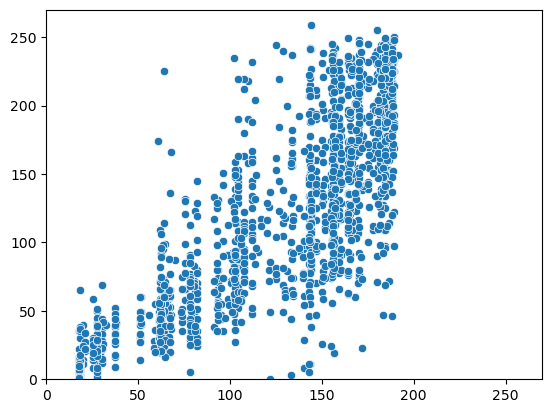

In [45]:
sns.scatterplot(y_pred_ada,y_test)
plt.xlim(0,270)
plt.ylim(0,270);

### GradientBoost

In [46]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col
player_pos = X_test.pos_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('grad',GradientBoostingRegressor(random_state=42))
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'grad__n_estimators':[94],
    'grad__learning_rate':[.05],
#     'grad__loss':['absolute_error','squared_error','huber','quantile'],
    'grad__min_samples_split':[2],
    'grad__min_samples_leaf':[1],
    'grad__max_depth':[4],
    'grad__min_impurity_decrease':[.31]
}

grad = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [47]:
start_time = time.time()
grad.fit(X_train,y_train)
print(((time.time() - start_time)/60),'minutes')
y_pred_grad = grad.predict(X_test)
print(r2_score(y_test,y_pred_grad),mean_squared_error(y_test,y_pred_grad));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

1.7152868310610454 minutes
0.6524671286024645 1725.1243838054565


In [26]:
results = pd.concat([player_name.reset_index(),player_round.reset_index(),player_year.reset_index(),X_test.reset_index(),pd.Series(y_pred_forest),pd.Series(y_test)],axis=1)

In [27]:
results

,index,player_col,index,Round_col,index,year_col,index,weight_x_col,height_x_col,pos_rk_col,...,valu,versatil,well,work,yard,year,year starter,zone,0,1
0,1073,DeAndre Wright,1073,6,1073,2009.0,1073,198.0,70.750,41.0,...,0.00000,0.000000,0.287967,0.000000,0.000000,0.000000,0.000000,0.0,197.491522,199
1,144,Adrian McPherson,144,5,144,2005.0,144,218.0,75.500,9.0,...,0.00000,0.000000,0.098724,0.000000,0.000000,0.083411,0.000000,0.0,122.438628,151
2,2380,Jon Feliciano,2380,4,2380,2015.0,2380,323.0,75.875,17.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,180.162967,127
3,184,DeAndra Cobb,184,6,184,2005.0,184,196.0,69.750,24.0,...,0.00000,0.082646,0.000000,0.000000,0.218138,0.063405,0.000000,0.0,185.659216,200
4,2587,Kyler Fackrell,2587,3,2587,2016.0,2587,245.0,77.000,10.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,136.120561,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,2282,Phillip Dorsett,2282,1,2282,2015.0,2282,185.0,69.750,6.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,22.904472,28
1385,2986,Treyvon Hester,2986,7,2986,2017.0,2986,300.0,74.375,20.0,...,0.19871,0.000000,0.000000,0.165464,0.000000,0.250062,0.179509,0.0,176.562856,243
1386,1078,Ra'Shon Harris,1078,6,1078,2009.0,1078,298.0,75.750,24.0,...,0.00000,0.000000,0.000000,0.404393,0.000000,0.000000,0.000000,0.0,176.756801,204
1387,1413,Martez Wilson,1413,3,1413,2011.0,1413,250.0,76.000,4.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,68.086397,71


In [28]:
results['difference'] = (results[0] + 1) - results[1]
results['abs_difference'] = ((results[0] + 1) - results[1]).abs()

In [29]:
results.difference

0       -0.508478
1      -27.561372
2       54.162967
3      -13.340784
4       50.120561
          ...    
1384    -4.095528
1385   -65.437144
1386   -26.243199
1387    -1.913603
1388   -36.216071
Name: difference, Length: 1389, dtype: float64

In [30]:
results.abs_difference.mean()

31.285690339848223

<AxesSubplot:xlabel='abs_difference', ylabel='Count'>

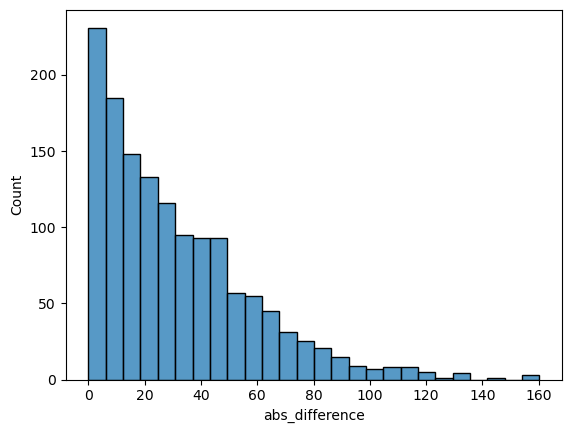

In [31]:
sns.histplot(results.abs_difference)

In [32]:
best = results[results.abs_difference <= 16]

In [33]:
best

,index,player_col,index,Round_col,index,year_col,index,weight_x_col,height_x_col,pos_rk_col,...,well,work,yard,year,year starter,zone,0,1,difference,abs_difference
0,1073,DeAndre Wright,1073,6,1073,2009.0,1073,198.0,70.750,41.0,...,0.287967,0.0,0.000000,0.000000,0.0,0.0,197.491522,199,-0.508478,0.508478
3,184,DeAndra Cobb,184,6,184,2005.0,184,196.0,69.750,24.0,...,0.000000,0.0,0.218138,0.063405,0.0,0.0,185.659216,200,-13.340784,13.340784
5,2768,Charles Harris,2768,1,2768,2017.0,2768,253.0,74.750,1.0,...,0.000000,0.0,0.000000,0.273181,0.0,0.0,28.227234,21,8.227234,8.227234
9,2862,Mack Hollins,2862,4,2862,2017.0,2862,221.0,76.000,10.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,107.382873,117,-8.617127,8.617127
11,3290,Irv Smith Jr.,3290,2,3290,2019.0,3290,242.0,74.375,3.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,42.369706,49,-5.630294,5.630294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,3053,D.J. Chark,3053,2,3053,2018.0,3053,199.0,74.875,6.0,...,0.000000,0.0,0.422382,0.000000,0.0,0.0,56.287772,60,-2.712228,2.712228
1379,2042,Brandin Cooks,2042,1,2042,2014.0,2042,189.0,69.750,4.0,...,0.398851,0.0,0.000000,0.000000,0.0,0.0,21.314060,19,3.314060,3.314060
1380,1632,Casey Hayward,1632,2,1632,2012.0,1632,192.0,71.375,8.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,63.302687,61,3.302687,3.302687
1384,2282,Phillip Dorsett,2282,1,2282,2015.0,2282,185.0,69.750,6.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,22.904472,28,-4.095528,4.095528


In [34]:
worst = results[results.abs_difference >= 64]

In [35]:
best.Round_col.value_counts(normalize=True)

1    0.256863
6    0.166667
5    0.152941
2     0.15098
3     0.12549
4    0.115686
7    0.031373
Name: Round_col, dtype: Float64

In [36]:
worst.Round_col.value_counts(normalize=True)

7    0.322981
3    0.267081
6    0.118012
2    0.093168
1    0.080745
4    0.068323
5    0.049689
Name: Round_col, dtype: Float64

In [37]:
best_pos = best.pos_col.value_counts(normalize=True) - results.pos_col.value_counts(normalize=True)
worst_pos = worst.pos_col.value_counts(normalize=True) - results.pos_col.value_counts(normalize=True)

In [38]:
best_pos.sort_values(ascending=False)

WR    0.024347
DE    0.020010
OL    0.005569
P     0.003324
LS    0.001762
TE    0.000584
K    -0.000597
RB   -0.000839
DB   -0.001588
QB   -0.003015
DL   -0.003278
CB   -0.004701
DT   -0.004760
LB   -0.016707
S    -0.018672
FB         NaN
Name: pos_col, dtype: float64

In [39]:
worst_pos.sort_values(ascending=False)

S     0.035926
CB    0.024406
DB    0.021004
DT    0.018477
K     0.005943
OL    0.005630
DL    0.005223
P    -0.000268
LB   -0.006538
QB   -0.016729
RB   -0.018790
TE   -0.019340
WR   -0.025623
DE   -0.025721
FB         NaN
LS         NaN
Name: pos_col, dtype: float64

In [40]:
results.pos_col.value_counts(normalize=True)

OL    0.180706
LB    0.124550
WR    0.118790
DB    0.109431
DE    0.087833
RB    0.087113
DT    0.087113
QB    0.053996
TE    0.050396
CB    0.043916
S     0.032397
DL    0.007199
K     0.006479
P     0.006479
LS    0.002160
FB    0.001440
Name: pos_col, dtype: float64

In [41]:
best.pos_col.value_counts(normalize=True)

OL    0.186275
WR    0.143137
DB    0.107843
LB    0.107843
DE    0.107843
RB    0.086275
DT    0.082353
TE    0.050980
QB    0.050980
CB    0.039216
S     0.013725
P     0.009804
K     0.005882
LS    0.003922
DL    0.003922
Name: pos_col, dtype: float64

In [42]:
worst.pos_col.value_counts(normalize=True)

OL    0.186335
DB    0.130435
LB    0.118012
DT    0.105590
WR    0.093168
S     0.068323
CB    0.068323
RB    0.068323
DE    0.062112
QB    0.037267
TE    0.031056
K     0.012422
DL    0.012422
P     0.006211
Name: pos_col, dtype: float64

In [43]:
best.pos_col[best.Round_col == 1].value_counts(normalize=True)

OL    0.213740
DE    0.152672
WR    0.145038
QB    0.106870
LB    0.099237
DT    0.091603
RB    0.076336
DB    0.053435
CB    0.030534
TE    0.022901
DL    0.007634
Name: pos_col, dtype: float64

In [44]:
results.pos_col[results.Round_col == 1].value_counts(normalize=True)

OL    0.240642
DE    0.139037
WR    0.122995
QB    0.112299
LB    0.090909
DT    0.090909
RB    0.058824
DB    0.053476
CB    0.037433
TE    0.021390
S     0.021390
DL    0.010695
Name: pos_col, dtype: float64

<AxesSubplot:xlabel='abs_difference', ylabel='Count'>

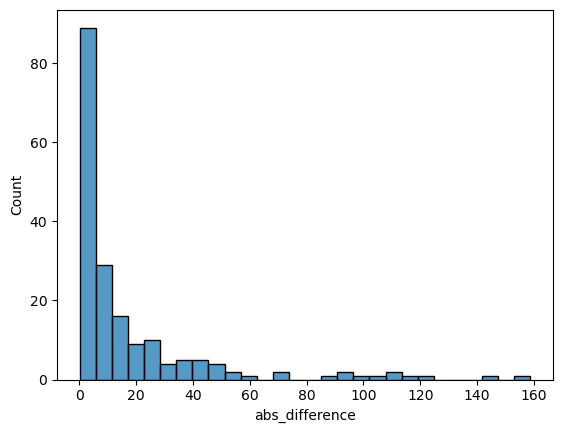

In [45]:
sns.histplot(results[results.Round_col == 1].abs_difference)

In [46]:
one_round = results[results.Round_col == 1]

In [47]:
one_round.develop

5       0.000000
21      0.000000
25      0.065799
31      0.155973
34      0.000000
          ...   
1349    0.000000
1371    0.000000
1373    0.000000
1379    0.000000
1384    0.000000
Name: develop, Length: 187, dtype: float64

In [48]:
miss_one = one_round[one_round.abs_difference > 32]

In [49]:
miss_one.develop.mean()

0.06017338390833614

In [50]:
one_round.develop.mean()

0.030089307317340747

In [51]:
results[results.Round_col == 1].abs_difference.mean()

18.2195100446098

In [52]:
results[results.Round_col == 2].abs_difference.mean()

26.718764442945727

In [53]:
results[results.Round_col == 3].abs_difference.mean()

37.75036580753132

In [54]:
results[results.Round_col == 4].abs_difference.mean()

31.015171146019707

In [55]:
results[results.Round_col == 5].abs_difference.mean()

25.852689576852764

In [56]:
results[results.Round_col == 6].abs_difference.mean()

27.615421730451228

In [57]:
results[results.Round_col == 7].abs_difference.mean()

52.52086027865428

In [62]:
cleaned_df[cleaned_df.Round_col == 1].groupby('pos_col').mean().sort_values(by='ovr_rk_col')

,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,target_col,...,tackles_assists_career_col,tackles_total_career_col,tackles_loss_career_col,sacks_career_col,pass_defended_career_col,fumbles_forced_season_col,fumbles_forced_career_col,speed_col,shuttle_agility_col,cone_agility_col
pos_col,,,,,,,,,,,,,,,,,,,,,
TE,2012.875000,251.062500,76.695312,1.312500,17.062500,91.625000,22.125000,1.0,20.3125,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.666030,144.407558,145.712496
DT,2013.204082,308.595745,75.111702,2.765957,17.489362,91.829787,22.083333,1.0,17.081633,3.0,...,54.066667,114.133333,22.888889,9.444444,4.388889,1.736842,2.379310,97.849975,136.961771,143.358176
QB,2013.962264,226.826923,75.509615,2.480769,18.192308,91.480769,22.134615,1.0,9.90566,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.558852,137.959072,133.613383
DE,2012.900000,270.151515,76.119318,2.909091,18.242424,91.818182,22.014493,1.0,15.742857,3.0,...,49.812500,118.468750,32.085938,18.460938,5.000000,2.500000,3.877193,109.577507,148.839163,146.681849
RB,2011.444444,217.138889,70.961806,2.111111,18.833333,92.083333,21.735294,1.0,17.138889,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.335770,132.875457,127.253084
WR,2014.043478,205.095238,73.043651,3.349206,20.476190,90.857143,21.692308,1.0,17.347826,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.740370,129.574828,123.432178
LB,2013.868852,244.793103,74.413793,2.310345,21.327586,90.603448,21.983333,1.0,16.836066,3.0,...,83.962963,196.481481,27.861111,12.000000,6.063830,2.451613,4.125000,110.896430,156.247868,141.032109
DB,2010.619048,199.245902,70.651639,2.750000,21.983333,91.483333,22.129032,1.0,18.936508,3.0,...,49.471698,159.037736,8.650943,2.208333,15.086957,1.444444,2.047619,103.610605,140.182586,126.084150
OL,2014.135922,313.936170,77.140957,2.563830,23.159574,90.255319,22.274510,1.0,16.834951,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.208684,133.981217,138.969886
